In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

from IPython.display import clear_output

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config("config.yaml")

In [3]:
rng = np.random.default_rng(123)
torch.manual_seed(123)

# num_paths = config.num_paths
# num_timesteps = config.num_timesteps
# final_time = config.final_time
# initial_price = config.initial_price
# decomp_dim = config.decomp_dim
# num_episodes = config.num_episodes
# batch_size = config.batch_size
# learning_rate = config.learning_rate

num_paths = 1
num_timesteps = 1000
final_time = 1
initial_price = 1
decomp_dim = 10
num_episodes = 10_000
batch_size = 1
dt = final_time / num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

kappa_true = 1
# permenant_price_impact_func = lambda x: kappa_true * x
permenant_price_impact_func = lambda x: kappa_true * np.sign(x) * np.sqrt(np.abs(x))

kernel_function = lambda x, y: 1 / (1 + np.abs(x - y) ** 0.5)
# kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x, y: np.exp(-np.abs((x - y))/(0.1))
K0 = kernel_function(0, 0)
KMIN = 0

nu_vals = rng.integers(-100, 100, size=(num_timesteps, num_paths))

max_price_impact = (kappa_true / 10) * np.abs(nu_vals).max()

# Generate Data

In [4]:
sigma_true = 0.01
sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

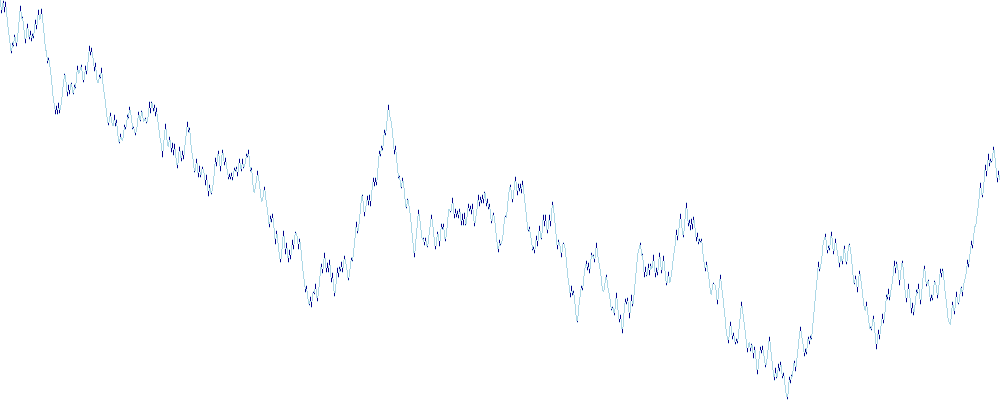

In [5]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# NN Approach

In [6]:
learning_rate = 1e-3

network = MLP(
    decomp_dim=decomp_dim,
    learn_price_impact=True,
    parameter_start=torch.FloatTensor([sigma_true]),
)
mtloss = MultiTaskLoss(num_losses=6, lagrangian=True)

optimizer = torch.optim.Adam(
    params=[*network.parameters(),
            *mtloss.parameters()], lr=learning_rate
)
# parameter_optimizer = torch.optim.Adam(
#     params=network.model_parameters.parameters(), lr=1e-3
# )

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=50)
scheduler_steps = 10
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1.0, end_factor=0.01, total_iters=scheduler_steps
)

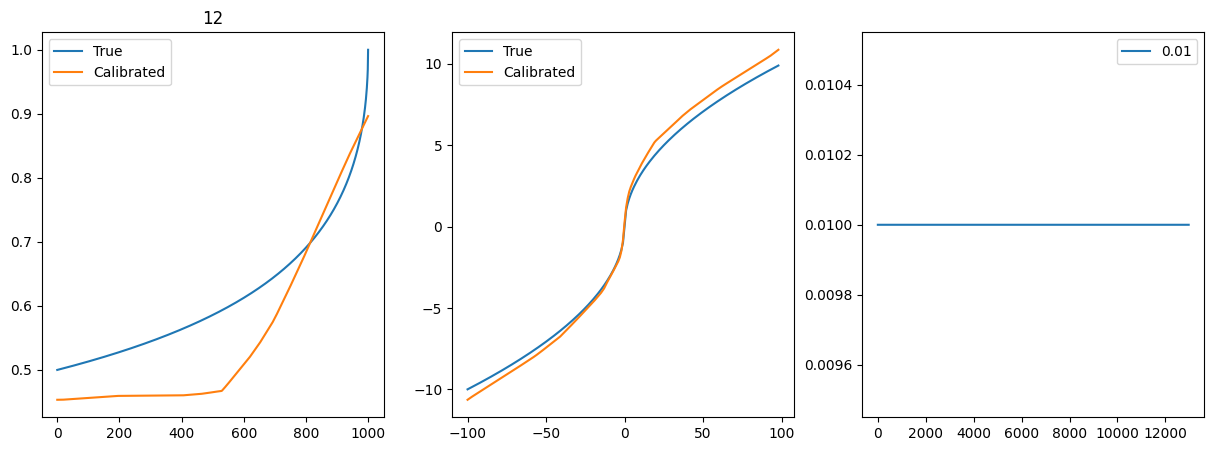

In [7]:
pi_train_flag = True
pi_flag_counter = 0

loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in range(1, int(num_paths / batch_size) + 1):

        lower_bound = int((batch_index - 1) * batch_size)
        upper_bound = int((batch_index) * batch_size)

        B_n_t = torch.zeros((batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, num_timesteps - 1)

        # Shuffle Timestamps
        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            pi_flag_counter += 1

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = network.permenant_price_impact_func(
                batch_nu_vals_t
            ).reshape(batch_size)

            time_tensor = torch.FloatTensor([num_timesteps * dt])
            f_vals = network(time_tensor)
            K_t_t = network.approx_func(
                time_tensor.reshape(-1, 1), time_tensor.reshape(-1, 1)
            ).flatten()
            # K_t_t = torch.FloatTensor([1])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)
            all_time_tensor = (
                torch.arange(num_timesteps - timestep, num_timesteps) * dt
            ).reshape(-1, 1)
            B_n_t = torch.zeros((1, batch_size, decomp_dim))
            d_B_n_s = (
                network(all_time_tensor).reshape(timestep, 1, decomp_dim)
                * network.permenant_price_impact_func(
                    torch.FloatTensor(batch_nu_vals[:timestep]).reshape(
                        timestep, batch_size, 1
                    )
                ).reshape(timestep, batch_size, 1)
                * dt
            )

            # Do I want [:-1] or not?
            B_n_t = torch.vstack([B_n_t, d_B_n_s])
            B_n_t = torch.sum(B_n_t, axis=0)

            delta = torch.FloatTensor([dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (network(time_plus_delta) - network(time_minus_delta)) / (2 * delta)
            ).flatten()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(batch_size) * K_t_t

            f_x_t_two = (
                B_n_t.reshape(batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = network.sigma.detach()
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * dt))

            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * dt) ** 2) / (
                2 * dt * (L_x_t**2)
            )

            likely_hood_loss = term_one + term_two
            ##################################################################################
            ##################################################################################
            ##################################################################################
            ##################################################################################
            time_one = torch.FloatTensor([[(num_timesteps) * dt]])
            time_two = torch.FloatTensor([[rng.integers(0, num_timesteps) * dt]])

            K_one_one = network.approx_func(time_one, time_one).flatten()

            # Ensure K(t,t) = 1
            # kernel_error_one = torch.abs(K_one_one - 1)
            kernel_error_one = torch.abs(K_t_t - 1)
            ##################################################################################
            K_one_two = network.approx_func(time_one, time_two).flatten()

            # Ensure K(s,t) < 1
            kernel_error_two = torch.maximum(
                torch.zeros_like(K_one_two), K_one_two - K0
            )
            ##################################################################################
            # Ensure that K(s,t) > 0
            kernel_error_seven = torch.maximum(
                torch.zeros_like(K_one_two), KMIN - K_one_two
            )
            ##################################################################################
            delta_two = dt
            f_prime_s = (
                network(time_two + delta_two) - network(time_two - delta_two)
            ) / (2 * delta_two)
            k_prime_t_s = (network(time_one) * f_prime_s).sum(dim=-1).flatten()
            # Want the grad: k'(t,s) < 0 for s>t and k'(t,s) > 0 for s<t
            if time_one.flatten().detach().item() > time_two.flatten().detach().item():
                kernel_error_ten = torch.maximum(
                    torch.zeros_like(k_prime_t_s), -k_prime_t_s
                )
            else:
                kernel_error_ten = torch.maximum(
                    torch.zeros_like(k_prime_t_s), k_prime_t_s
                )
            ##################################################################################
            delta_two = dt
            f_prime_s = (
                network(time_two + delta_two) - 2*network(time_two) - network(time_two - delta_two)
            ) / (4 * delta_two**2)
            k_prime_t_s = (network(time_one) * f_prime_s).sum(dim=-1).flatten()
            # Want the grad: k'(t,s) < 0 for s>t and k'(t,s) > 0 for s<t
            if time_one.flatten().detach().item() > time_two.flatten().detach().item():
                kernel_error_twelve = torch.maximum(
                    torch.zeros_like(k_prime_t_s), -k_prime_t_s
                )*dt
            else:
                kernel_error_twelve = torch.maximum(
                    torch.zeros_like(k_prime_t_s), k_prime_t_s
                )*dt
            ##################################################################################
            delta_two = dt
            f_prime_s = (network(time_one) - network(time_one - delta_two)) / (
                delta_two
            )
            k_prime_t_s = (network(time_one) * f_prime_s).sum(dim=-1).flatten()

            eps = 1
            # Want the grad: k'(t,s) < 0 for s>t and k'(t,s) > 0 for s<t
            kernel_error_eleven = torch.maximum(
                torch.zeros_like(k_prime_t_s), eps - k_prime_t_s
            )
            ##################################################################################
            price_impact_loss_one = torch.abs(
                network.price_impact(torch.zeros((1, 1)))
            ).mean()
            ##################################################################################

            loss_tensor = torch.hstack(
                [
                    likely_hood_loss.mean(),
                    (kernel_error_one).mean(),
                    (kernel_error_two).mean(),
                    (kernel_error_seven).mean(),
                    (kernel_error_ten).mean(),
                    (kernel_error_eleven).mean(),
                    # (kernel_error_twelve).mean()
                    # (price_impact_loss_one).mean()
                ]
            )

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = mtloss(loss_tensor)

            sigma_tracker[episode].append(network.sigma.detach().item())
            loss_vals[episode].append(
                {
                    "mt_loss": loss.detach().item(),
                    **{i: _.detach().item() for i, _ in enumerate(loss_tensor)},
                }
            )

            if pi_flag_counter % 100 == True:
                pi_train_flag = not pi_train_flag

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

        scheduler.step()

    if episode % 1 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []
        pi_plot = []
        pi_plot_true = []

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        for i in range(num_timesteps - int(s_val), num_timesteps + 1):
            k_s_t = network.approx_func(
                torch.FloatTensor([num_timesteps * dt]).reshape(-1, 1),
                torch.FloatTensor([i * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for i in range(num_timesteps - int(s_val), num_timesteps + 1):
            val = kernel_function(x=i * dt, y=num_timesteps * dt)
            kernel_plot_two.append(val)

        # max_k_val = max(kernel_plot)
        max_k_val = 1
        kernel_plot = [_ / max_k_val for _ in kernel_plot]

        for plot_val in range(nu_vals.min(), nu_vals.max()):
            pred_pi = network.permenant_price_impact_func(torch.FloatTensor([plot_val]))
            pi_plot.append(pred_pi.detach().item() * max_k_val)

        for plot_val in range(nu_vals.min(), nu_vals.max()):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        ax[0].set_title(episode)
        ax[0].plot(kernel_plot_two, label="True")
        ax[0].plot(kernel_plot, label="Calibrated")
        ax[0].legend()

        ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot_true, label="True")
        ax[1].plot(range(nu_vals.min(), nu_vals.max()), pi_plot, label="Calibrated")
        ax[1].legend()

        ax[2].plot(
            np.hstack([_ for _ in sigma_tracker.values()]),
            label=round(network.sigma.item(), 3),
        )
        ax[2].legend()

        plt.show()

    if episode > scheduler_steps/2:
        max_key = max(loss_vals.keys())
        minus_one_key = max(max(loss_vals.keys()) - 1, 0)

        mean_one = pd.concat(
            [pd.DataFrame(loss_vals[key])[0] for key in range(max_key -1, max_key)]
        ).mean()
        mean_two = pd.concat(
            [
                pd.DataFrame(loss_vals[key])[0]
                for key in range(minus_one_key - 1, minus_one_key)
            ]
        ).mean()

        if mean_one > 0.90*mean_two:
            break

    if episode == scheduler_steps*2:
        break

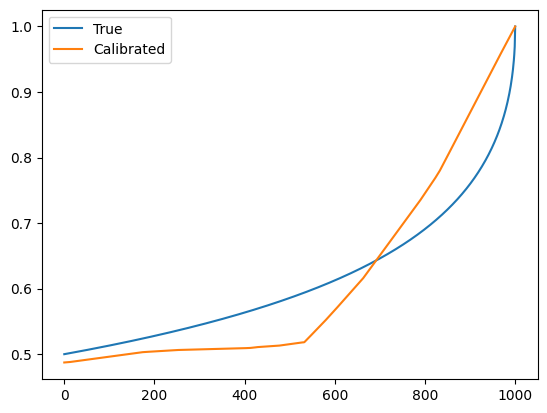

In [ ]:
s = 1
s_val = num_timesteps * s
kernel_plot = []
kernel_plot_two = []

for i in range(0, num_timesteps+1):
    k_s_t = network.approx_func(
        torch.FloatTensor([s_val * dt]).reshape(-1, 1),
        torch.FloatTensor([i * dt]).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

max_k_val = max(kernel_plot)

kernel_plot = [_ / max_k_val for _ in kernel_plot]

partial_func = partial(kernel_function, y=s_val * dt)
for i in range(0, num_timesteps+1):
    val = partial_func(i * dt)
    kernel_plot_two.append(val)

plt.plot(range(0, num_timesteps+1), kernel_plot_two, label="True")
plt.plot(range(0, num_timesteps+1), kernel_plot, label="Calibrated")
plt.legend()
plt.show()

# Validation Prices

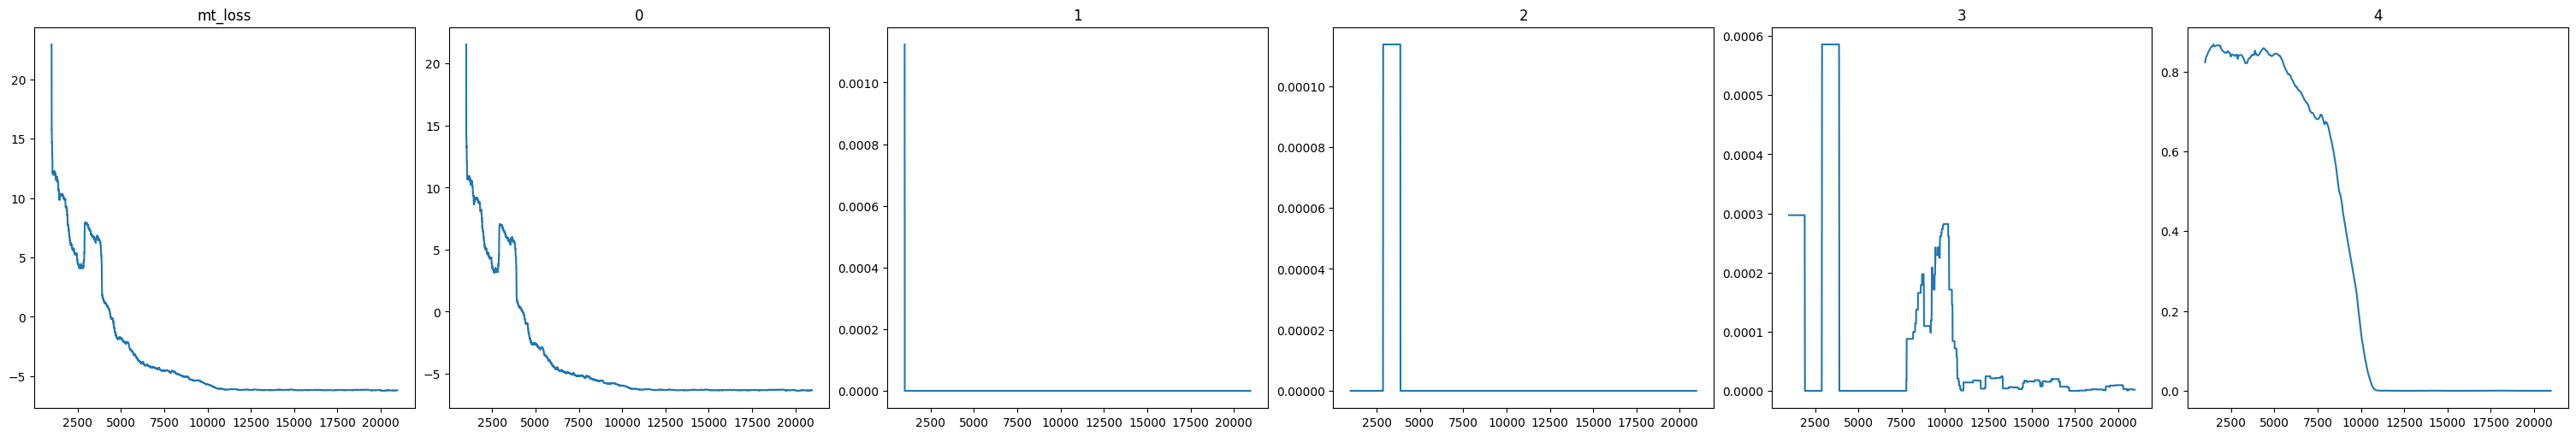

In [ ]:
loss_types = tuple(loss_vals[0][0].keys())

fig, ax = plt.subplots(
    1, len(loss_types), figsize=(5 * len(loss_types), 5), constrained_layout=True
)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(
        pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()])
        .rolling(num_timesteps)
        .mean()
        .values
    )
    ax[plot_index].set_title(loss_type)

plt.show()

# Distribution Plots

In [ ]:
num_paths = 1_000
val_nu_vals = rng.integers(-80, 100, size=(num_timesteps, num_paths))

val_inital_prices = np.ones((1, num_paths)) * initial_price
val_sim_prices, _ = non_markovian_midprice(
    inital_prices=val_inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=val_nu_vals,
    kernel_function=kernel_function,
    dt=dt,
    rng=rng,
    num_paths=num_paths,
    num_timesteps=num_timesteps,
    sigma=sigma_true,
)

In [ ]:
network.eval()

sim_nu_vals = rng.uniform(-80, 100, size=(num_timesteps, num_paths))
all_time_tensor = (torch.arange(0, num_timesteps) * dt).reshape(-1, 1)

noise = np.zeros((1, num_paths))
d_W_t = (
    network.sigma.detach().item()
    * rng.standard_normal(size=(num_timesteps, num_paths))
    * (dt**0.5)
)
noise = np.vstack([noise, d_W_t])

S_t = torch.ones((1, num_paths)) * initial_price
B_n_t = torch.zeros((1, num_paths, decomp_dim)).detach().numpy()

d_B_n_s = (
    network(all_time_tensor).detach().numpy().reshape(num_timesteps, 1, decomp_dim)
    * network.numpy_permenant_price_impact_func(
        sim_nu_vals.reshape(num_timesteps, num_paths, 1)
    ).reshape(num_timesteps, num_paths, 1)
    * dt
)

B_n_t = np.vstack([B_n_t, d_B_n_s])[:-1]
B_n_t = np.cumsum(B_n_t, axis=0)

f_prime_t = (network(all_time_tensor+dt) - network(all_time_tensor-dt))/(2*dt)

f_prime_t = f_prime_t.detach().numpy().reshape(num_timesteps, 1, decomp_dim)

dt_term_one = network.numpy_permenant_price_impact_func(
    sim_nu_vals.reshape(num_timesteps, num_paths, 1)
).reshape(num_timesteps, num_paths) * network.approx_func(
    all_time_tensor, all_time_tensor
).detach().numpy().reshape(
    num_timesteps, 1
)
dt_term_two = (f_prime_t * B_n_t).sum(axis=2)

dt_term = (dt_term_one + dt_term_two) * dt

d_S_terms = dt_term + d_W_t

S_t = np.vstack([S_t, d_S_terms])
S_t = np.cumsum(S_t, axis=0)

nn_sim_prices = S_t

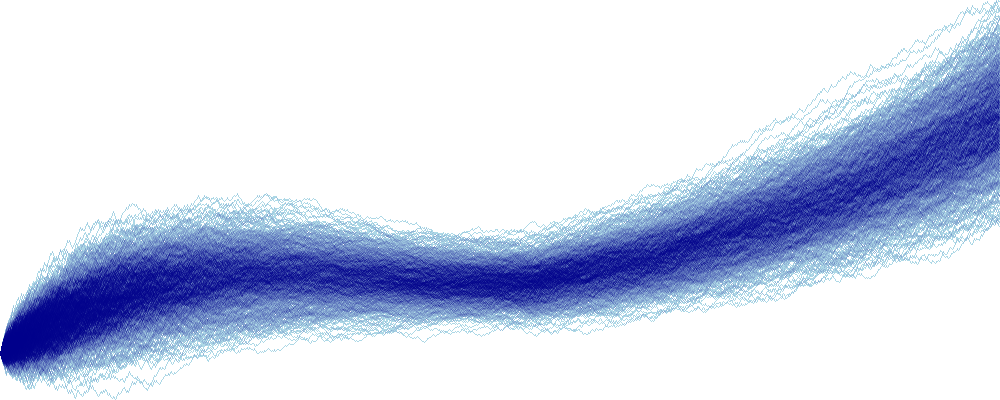

In [ ]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(
    walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0
)
img = tf.shade(agg, how="eq_hist")

img

# Distribution Plots

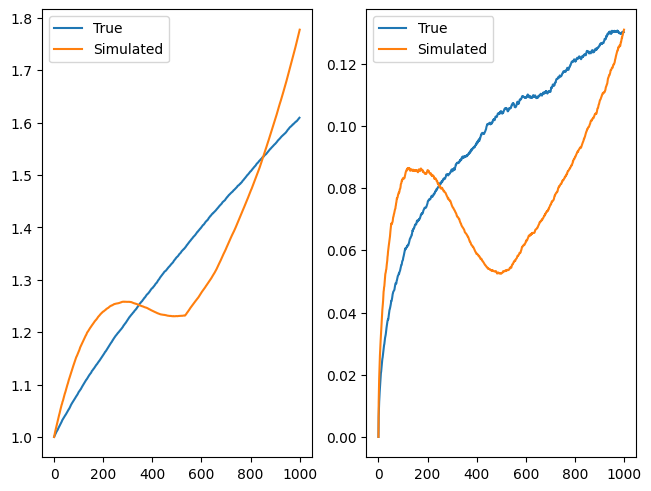

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

ax[0].plot(val_sim_prices[:, :10_000].mean(axis=1), label="True")
ax[0].plot(nn_sim_prices.mean(axis=1), label="Simulated")
ax[0].legend()

ax[1].plot(val_sim_prices[:, :10_000].std(axis=1), label="True")
ax[1].plot(nn_sim_prices.std(axis=1), label="Simulated")
ax[1].legend()

plt.show()

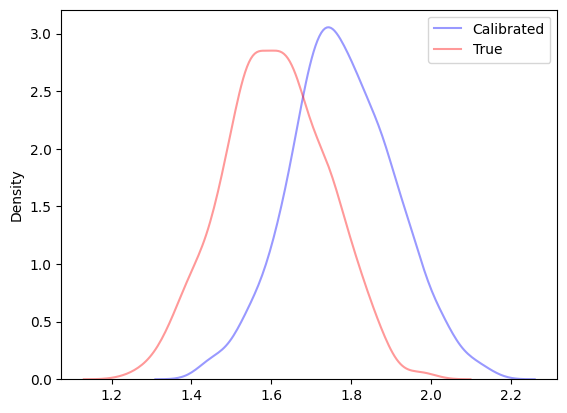

In [ ]:
final_sim_prices = nn_sim_prices[-1]
final_val_sim_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color="blue", label="Calibrated")
sns.kdeplot(final_val_sim_prices, alpha=0.4, color="red", label="True")
plt.legend()
plt.show()